In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os


alerts_df3 = pd.read_csv("./combined_status_tracker.csv")
#print(alerts_df3)

In [78]:
alerts_df3.columns

Index(['Park Alpha', 'Status', 'park alpha', 'Park Name', 'Park Full Name',
       'Type of Unit', 'State', 'Reg', 'title', 'description', 'category',
       'relatedRoadEvents', 'date', 'Column Labels'],
      dtype='object')

In [79]:
# Ensure 'date' is in datetime format and reads all the various formats from the combined_status_tracker
alerts_df3['date'] = pd.to_datetime(alerts_df3['date'],format='mixed')

# Filter for the latest date in each month
alerts_df3['year_month'] = alerts_df3['date'].dt.to_period('M')
latest_dates = alerts_df3.groupby('year_month')['date'].max().reset_index()
filtered_df = pd.merge(alerts_df3, latest_dates[['date']], on='date')
filtered_df.dropna(subset=['description'], inplace=True)
filtered_df.drop_duplicates(subset=['Park Alpha', 'description', 'date'], inplace=True)
filtered_df = filtered_df.reset_index()


In [80]:
road_closed_flag_list = []
winter_flag_list = []
summer_flag_list = []
extreme_flag_list = []
wildfire_flag_list = []
construction_flag_list = []
all_weather_flags_list = []

winter_words_list= ['snow', 'ice', 'sleet', 'blizzard', 'frost', 'freeze']
summer_words_list= ['heat', 'hot', 'humid', 'drought', 'sun', 'warm']
extreme_words_list = ['storm', 'flood', 'tornado', 'hurricane', 'thunder', 'lightning', 'landslide', 'earthquake']
wildfire_words_list = ['wildfire', 'fire']
construction_words_list =['construction', 'repair', 'paving', 'detour', 'maintenance']
road_words_list = ["road", "route", "interstate", "highway", "vehic"]
all_weather_words_list = ['snow', 'ice', 'sleet', 'blizzard', 'frost', 'freeze',
                         'heat', 'hot', 'humid', 'drought', 'sun', 'warm',
                         'storm', 'flood', 'tornado', 'hurricane', 'thunder', 'lightning', 'landslide', 'earthquake',
                         'wildfire', 'fire']

for x in range(len(filtered_df)): 
    road_closed_flag = 0
    winter_flag = 0
    summer_flag = 0
    extreme_flag = 0
    wildfire_flag = 0
    construction_flag = 0
    all_weather_flags = 0
    
    for y in road_words_list:
     #   print(filtered_df["description"][x])
        if y in str(filtered_df["description"][x].lower()):
            road_closed_flag = 1
            break

    for y in winter_words_list:
        if y in str(filtered_df["description"][x].lower()):
            winter_flag = 1
            break

    for y in summer_words_list:
        if y in str(filtered_df["description"][x].lower()):
            summer_flag = 1
            break

    for y in extreme_words_list:
        if y in str(filtered_df["description"][x].lower()):
            extreme_flag = 1
            break

    for y in wildfire_words_list:
        if y in str(filtered_df["description"][x].lower()):
            wildfire_flag = 1
            break

    for y in construction_words_list:
        if y in str(filtered_df["description"][x].lower()):
            construction_flag = 1
            break

    for y in all_weather_words_list:
        if y in str(filtered_df["description"][x].lower()):
            all_weather_flags = 1
            break 

    road_closed_flag_list.append(road_closed_flag)
    winter_flag_list.append(winter_flag)
    summer_flag_list.append(summer_flag)
    extreme_flag_list.append(extreme_flag)
    wildfire_flag_list.append(wildfire_flag)
    construction_flag_list.append(construction_flag)
    all_weather_flags_list.append(all_weather_flags)

filtered_df["Road Closed Flag"] = road_closed_flag_list
filtered_df["Winter"] = winter_flag_list
filtered_df["Summer"] = summer_flag_list
filtered_df["Extreme Weather"] = extreme_flag_list
filtered_df["Wildfire"] = wildfire_flag_list
filtered_df["Construction"] = construction_flag_list
filtered_df["Overall: Weather"] = all_weather_flags_list

In [81]:
len(filtered_df.loc[filtered_df["Road Closed Flag"]==0]), len(filtered_df.loc[filtered_df["Winter"]==1])

(0, 83)

In [82]:
monthly_df = filtered_df.groupby(['date']).sum(numeric_only=True).reset_index()
monthly_df['year_month'] = monthly_df['date'].dt.to_period('M').dt.to_timestamp()
monthly_df['Unknown'] = monthly_df['Road Closed Flag'] - monthly_df['Winter'] - monthly_df['Summer'] - monthly_df['Extreme Weather'] - monthly_df['Wildfire'] - monthly_df['Construction']
monthly_df['Overall: Weather'] = monthly_df['Winter'] + monthly_df['Summer'] + monthly_df['Extreme Weather'] + monthly_df['Wildfire'] 

monthly_df['months'] = monthly_df.date.dt.strftime("%b %Y")
monthly_df

,date,index,Column Labels,Road Closed Flag,Winter,Summer,Extreme Weather,Wildfire,Construction,Overall: Weather,year_month,Unknown,months
0,2024-04-29,63054,0.0,124,22,9,12,1,34,44,2024-04-01,46,Apr 2024
1,2024-05-22,44735,0.0,115,21,8,13,2,30,44,2024-05-01,41,May 2024
2,2024-06-17,30744,0.0,112,17,8,11,5,29,41,2024-06-01,42,Jun 2024
3,2024-07-31,17383,0.0,107,11,8,11,9,29,39,2024-07-01,39,Jul 2024
4,2024-08-22,5837,0.0,108,12,9,12,9,27,42,2024-08-01,39,Aug 2024


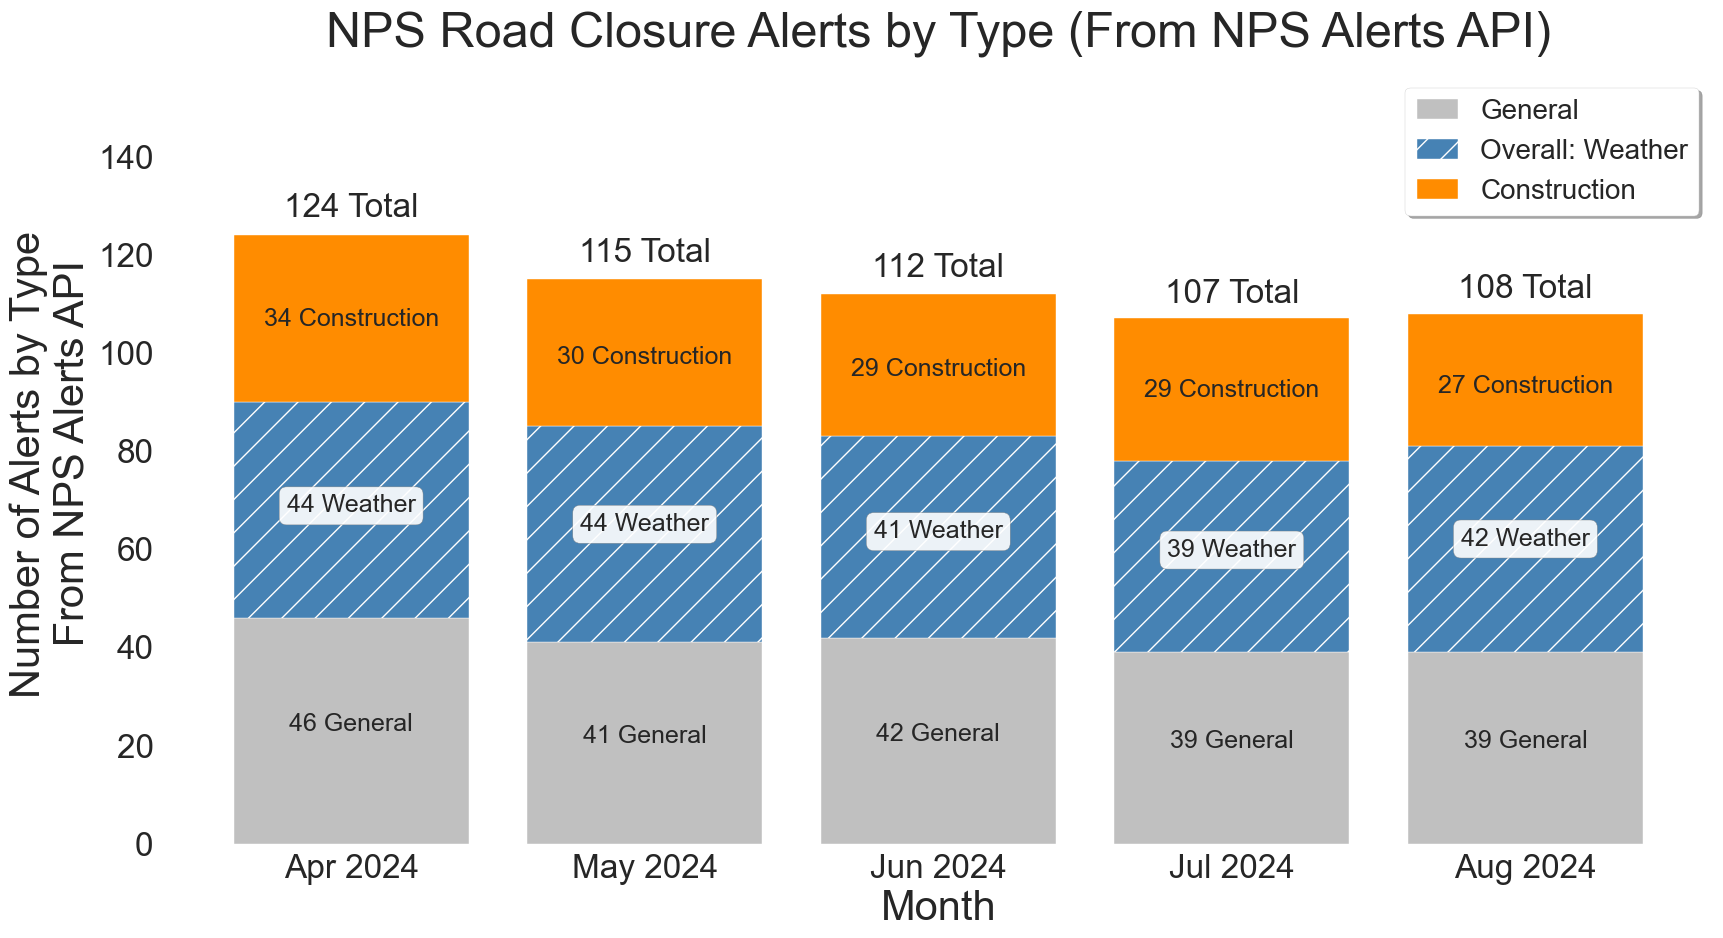

In [83]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
graph_title = "NPS Road Closure Alerts by Type (From NPS Alerts API)"
axis_title = "Number of Alerts by Type \n From NPS Alerts API"
plt.style.use("seaborn-v0_8")
sns.set_style("white")

#plt.color_palette("husl")
cmap = mpl.cm.cool
fig, ax = plt.subplots(1,1,figsize=(20,10))
tick_spacing = 1


plt.bar(monthly_df['months'],
        monthly_df['Unknown'], label = "General", color = "silver")

plt.bar(monthly_df['months'],
        monthly_df['Overall: Weather'], label = "Overall: Weather", bottom = monthly_df['Unknown'], hatch = "/",
       color = "steelblue")

plt.bar(monthly_df['months'],
        monthly_df['Construction'],  bottom = monthly_df['Unknown']+ monthly_df['Overall: Weather'],
label = "Construction", color = "darkorange")


bar_max = 1.15*monthly_df['Road Closed Flag'].max()

for i in range(len(monthly_df['months'])):
    plt.text(i, monthly_df['Road Closed Flag'][i]*1.03, str(monthly_df['Road Closed Flag'][i]) + " Total", ha = 'center',  fontsize = 24)

for i in range(len(monthly_df['months'])):
    plt.text(i, monthly_df['Unknown'][i]*.5, str(monthly_df['Unknown'][i]) + " General", ha = 'center',  fontsize = 18)

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

for i in range(len(monthly_df['months'])):
    plt.text(i, (monthly_df['Unknown'][i]+monthly_df['Overall: Weather'][i])*.75, str(monthly_df['Overall: Weather'][i]) + " Weather", 
             ha = 'center',  fontsize = 18, bbox=bbox_props)

for i in range(len(monthly_df['months'])):
    plt.text(i, monthly_df['Road Closed Flag'][i]*.85, str(monthly_df['Construction'][i]) + " Construction", ha = 'center',  fontsize = 18)


#make graph pretty
ax.set_ylim([0, bar_max*1.1])
#ax.set_xlim([0, 460])
ax.set_title(graph_title,fontsize= 35, pad = 20) # title of plot

ax.set_xlabel('Month',fontsize = 30) #xlabel
ax.set_ylabel(axis_title, fontsize = 30)#ylabel
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis='x', which='major', labelsize=24)
ax.tick_params(axis='y', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.grid('off')
ax.legend(fontsize = 20, frameon=True,fancybox = True,shadow=True, handlelength=1.5,framealpha=1, )
plt.grid(False)

output_dir = 'Figures/Combined across Regions'
os.makedirs(output_dir, exist_ok=True)

# Save the figure as a PNG file at 150 DPI
output_path = os.path.join(output_dir, 'overall_alerts_api_types.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')

plt.show()

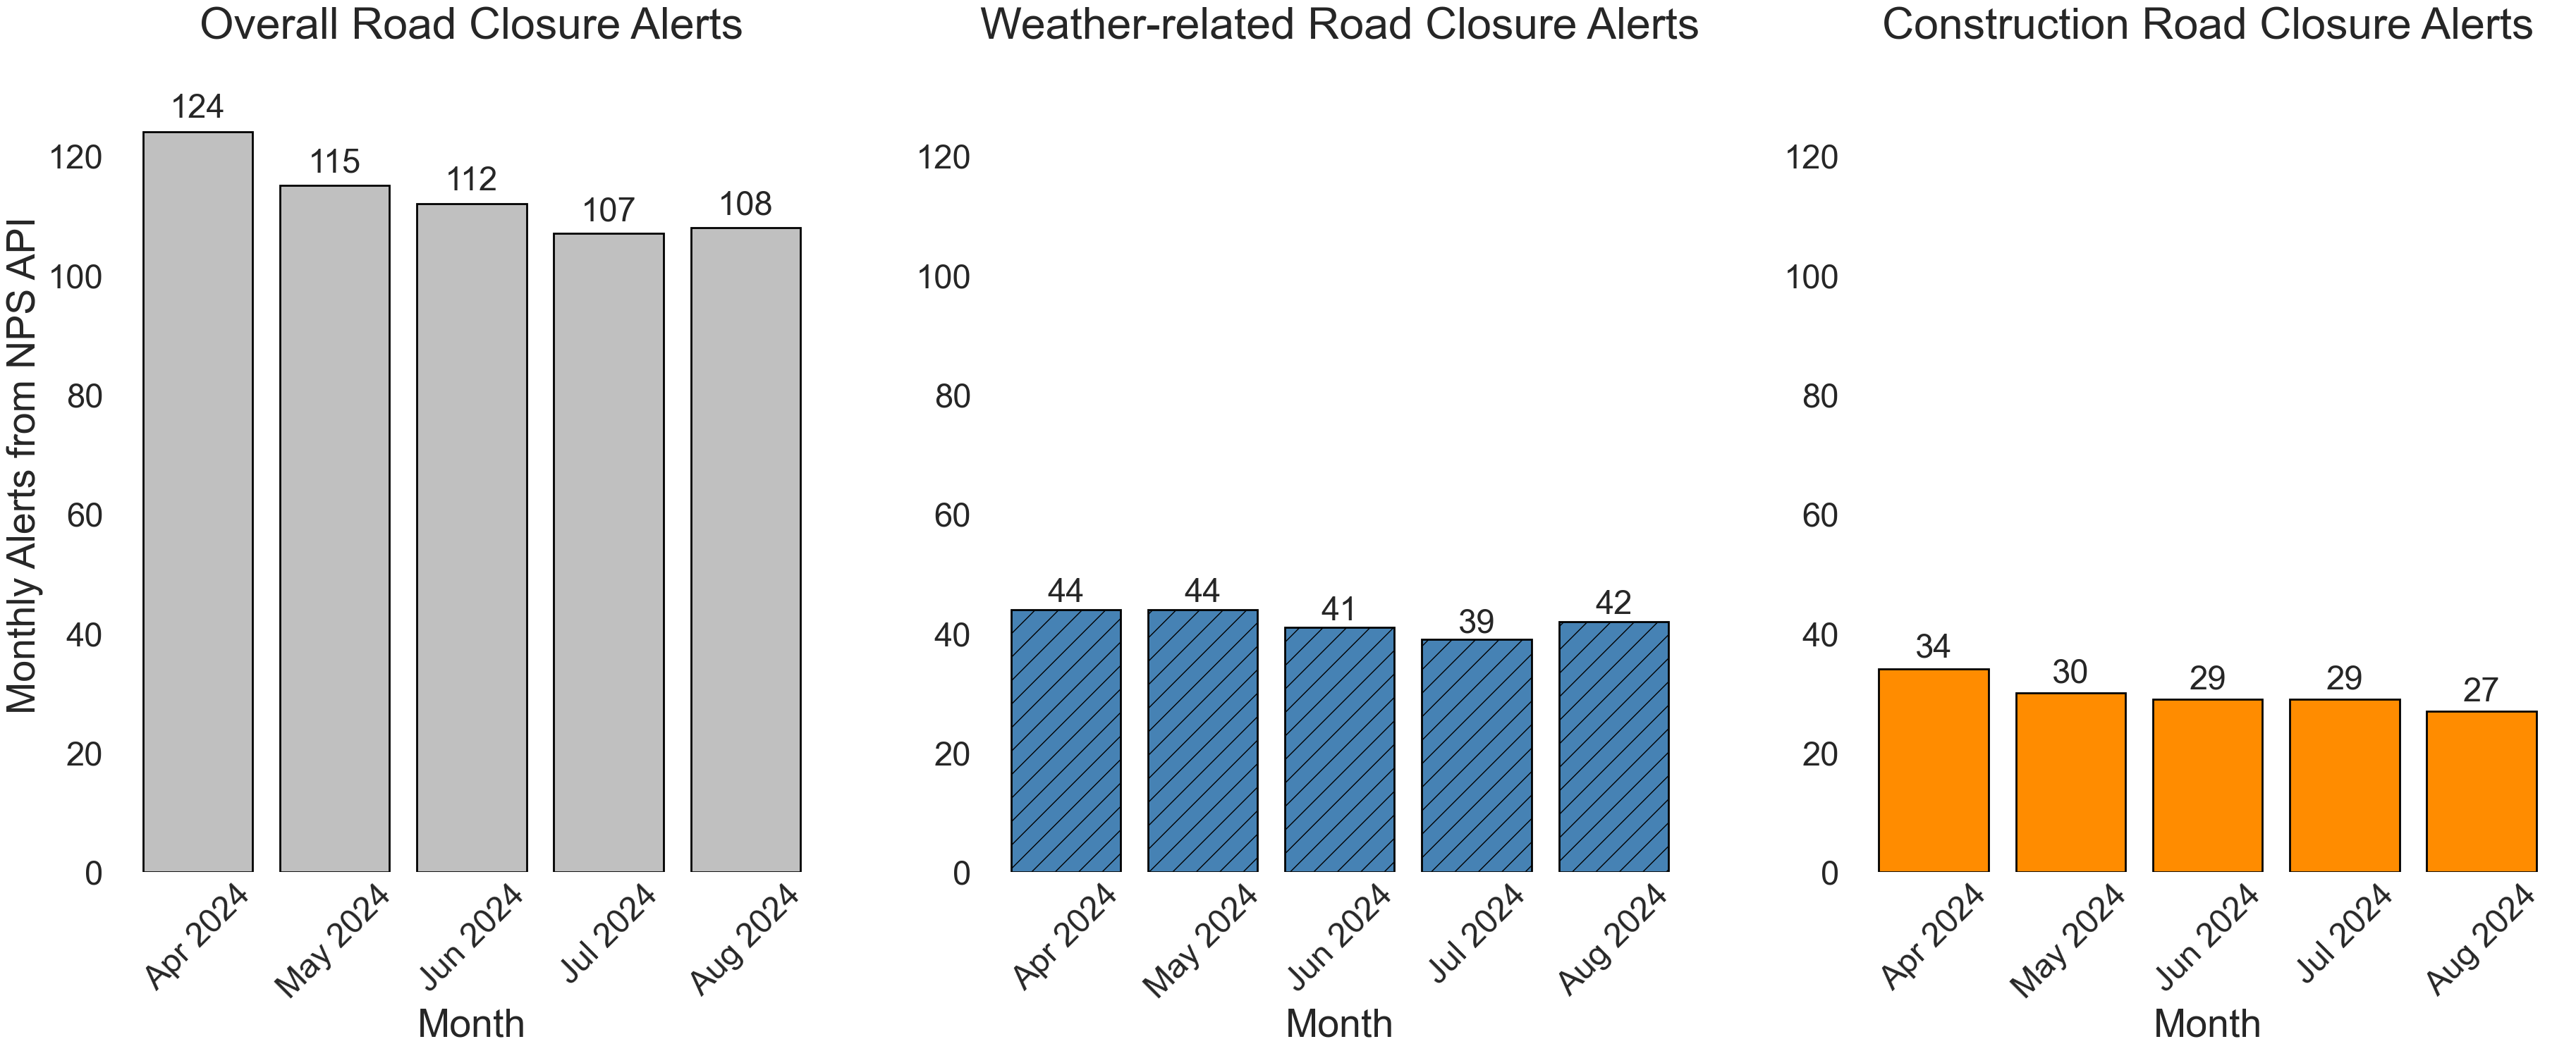

In [84]:
fig, ax = plt.subplots(1,3,figsize=(45,15))

tick_spacing = 1
graph_title_total = "Overall Road Closure Alerts"
graph_title_weather = "Weather-related Road Closure Alerts"
graph_title_construction = "Construction Road Closure Alerts"
xaxis_title = "Month"
yaxis_title = "Monthly Alerts from NPS API"

#subplot data
ax[0].bar(monthly_df['months'], monthly_df['Road Closed Flag'], edgecolor="black", linewidth=2, color = 'silver')
ax[1].bar(monthly_df['months'], monthly_df['Overall: Weather'], edgecolor="black", linewidth=2, hatch = "/", color = "steelblue")
ax[2].bar(monthly_df['months'], monthly_df['Construction'],  edgecolor="black", linewidth=2, color = "darkorange")

bar_max = 1.1*monthly_df['Road Closed Flag'].max()

for i in range(len(monthly_df['months'])):
    ax[0].text(i, monthly_df['Road Closed Flag'][i]*1.02, str(monthly_df['Road Closed Flag'][i]), ha = 'center',  fontsize = 34)

for i in range(len(monthly_df['months'])):
    ax[1].text(i, (monthly_df['Overall: Weather'][i])*1.03, str(monthly_df['Overall: Weather'][i]), 
             ha = 'center',  fontsize = 34)

for i in range(len(monthly_df['months'])):
    ax[2].text(i, monthly_df['Construction'][i]*1.06, str(monthly_df['Construction'][i]), ha = 'center',  fontsize = 34)


#make graph pretty
ax[0].set_ylim([0, bar_max])
ax[0].set_title(graph_title_total,fontsize= 45, pad = 20) # title of plot
ax[0].set_xlabel(xaxis_title,fontsize = 40) #xlabel
ax[0].set_ylabel(yaxis_title, fontsize = 40)#ylabel
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[0].tick_params(axis='x', which='major', labelsize=34, rotation=45)
ax[0].tick_params(axis='y', which='major', labelsize=34)
ax[0].tick_params(axis='both', which='minor', labelsize=8)
ax[0].grid('off')
ax[0].grid(False)

#make graph pretty
ax[1].set_ylim([0, bar_max])
ax[1].set_title(graph_title_weather,fontsize= 45, pad = 20) # title of plot
ax[1].set_xlabel(xaxis_title,fontsize = 40) #xlabel
#ax[1].set_ylabel(yaxis_title, fontsize = 30)#ylabel
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[1].tick_params(axis='x', which='major', labelsize=34, rotation=45)
ax[1].tick_params(axis='y', which='major', labelsize=34)
ax[1].tick_params(axis='both', which='minor', labelsize=8)
ax[1].grid('off')
ax[1].grid(False)

#make graph pretty
ax[2].set_ylim([0, bar_max])
ax[2].set_title(graph_title_construction,fontsize= 45, pad = 20) # title of plot
ax[2].set_xlabel(xaxis_title,fontsize = 40) #xlabel
#ax[2].set_ylabel(yaxis_title, fontsize = 30)#ylabel
ax[2].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[2].tick_params(axis='x', which='major', labelsize=34, rotation=45)
ax[2].tick_params(axis='y', which='major', labelsize=34)
ax[2].tick_params(axis='both', which='minor', labelsize=8)
ax[2].grid('off')
ax[2].grid(False)



output_dir = 'Figures/Combined across Regions'
os.makedirs(output_dir, exist_ok=True)

# Save the figure as a PNG file at 150 DPI
output_path = os.path.join(output_dir, 'overall_alerts_api_types_subplots.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')

plt.show()

In [85]:
monthly_df_reg = filtered_df.groupby(['date', "Reg"]).sum(numeric_only=True).reset_index()
monthly_df_reg['year_month'] = monthly_df_reg['date'].dt.to_period('M').dt.to_timestamp()
monthly_df_reg['Unknown'] = monthly_df_reg['Road Closed Flag'] - monthly_df_reg['Winter'] - monthly_df_reg['Summer'] - monthly_df_reg['Extreme Weather'] - monthly_df_reg['Wildfire'] - monthly_df_reg['Construction']
monthly_df_reg['Overall: Weather'] = monthly_df_reg['Winter'] + monthly_df_reg['Summer'] + monthly_df_reg['Extreme Weather'] + monthly_df_reg['Wildfire'] 

monthly_df_reg['months'] = monthly_df_reg.date.dt.strftime("%b %Y")
monthly_df_reg

,date,Reg,index,Column Labels,Road Closed Flag,Winter,Summer,Extreme Weather,Wildfire,Construction,Overall: Weather,year_month,Unknown,months
0,2024-04-29,AKR,1064,0.0,2,2,0,1,0,0,3,2024-04-01,-1,Apr 2024
1,2024-04-29,IMR,18665,0.0,37,7,2,3,0,8,12,2024-04-01,17,Apr 2024
2,2024-04-29,MWR,8681,0.0,17,4,2,1,0,5,7,2024-04-01,5,Apr 2024
3,2024-04-29,NCR,2568,0.0,5,2,0,0,0,4,2,2024-04-01,-1,Apr 2024
4,2024-04-29,NER,11237,0.0,22,1,2,3,0,8,6,2024-04-01,8,Apr 2024
5,2024-04-29,PWR,12585,0.0,25,6,1,4,1,5,12,2024-04-01,8,Apr 2024
6,2024-04-29,SER,8254,0.0,16,0,2,0,0,4,2,2024-04-01,10,Apr 2024
7,2024-05-22,AKR,860,0.0,2,2,0,1,0,0,3,2024-05-01,-1,May 2024
8,2024-05-22,IMR,13250,0.0,34,5,3,5,1,7,14,2024-05-01,13,May 2024
9,2024-05-22,MWR,5672,0.0,15,2,0,1,0,4,3,2024-05-01,8,May 2024


In [86]:
monthly_df_reg.Reg.unique()

array(['AKR', 'IMR', 'MWR', 'NCR', 'NER', 'PWR', 'SER'], dtype=object)

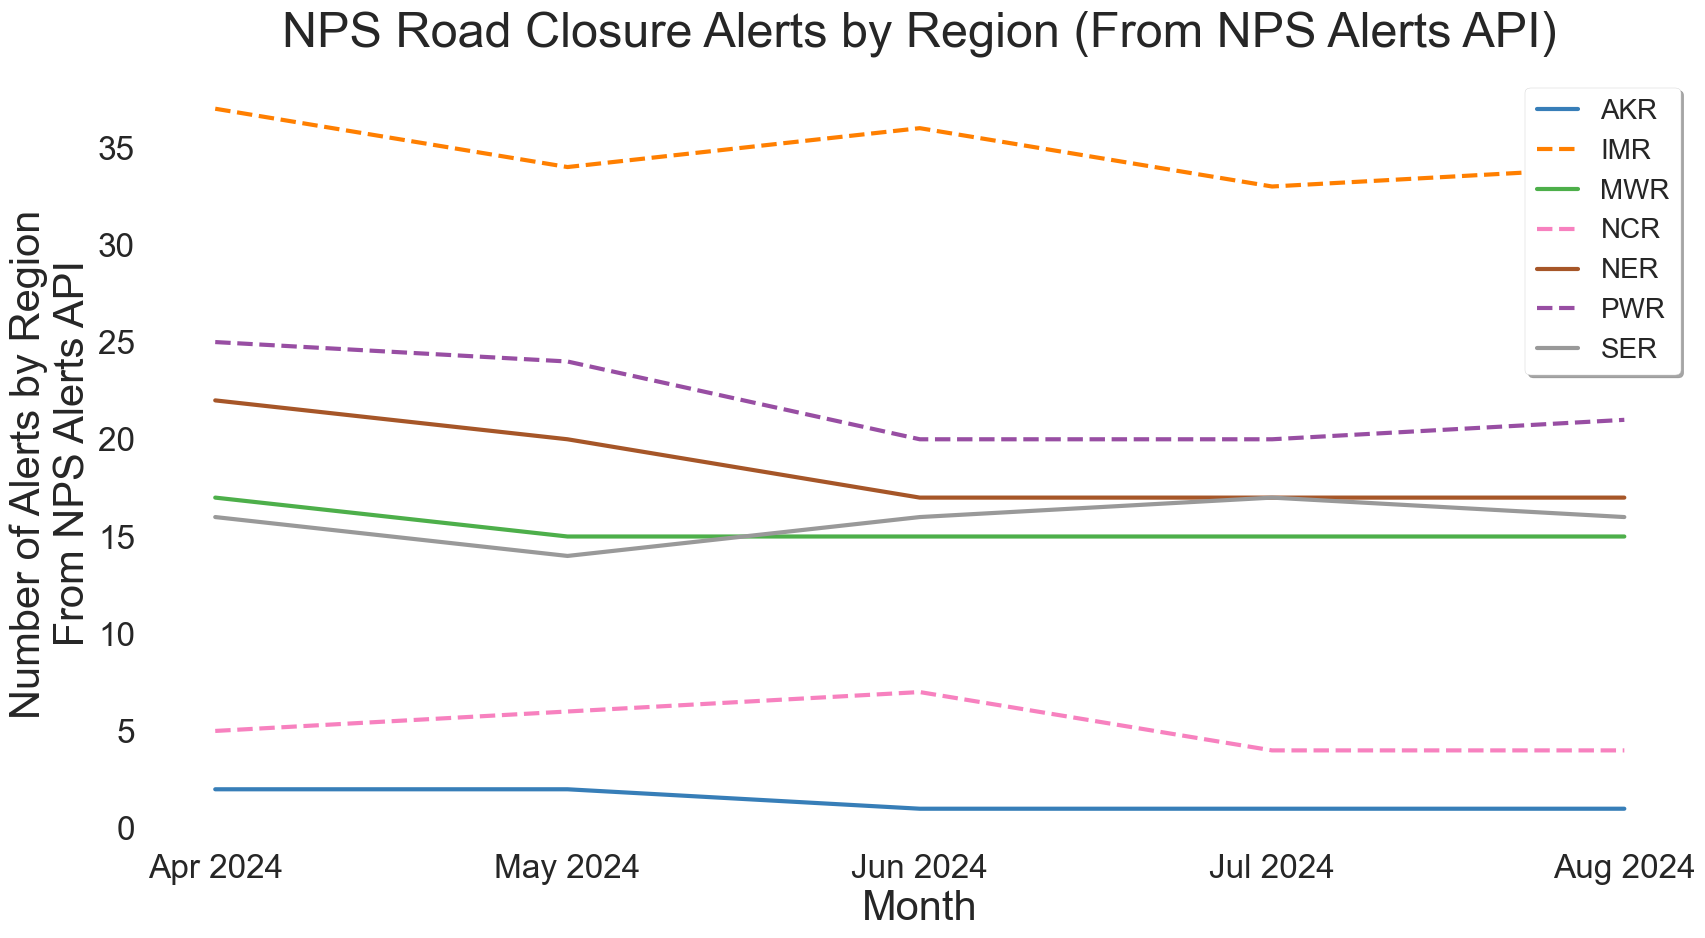

In [87]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
graph_title = "NPS Road Closure Alerts by Region (From NPS Alerts API)"
axis_title = "Number of Alerts by Region \n From NPS Alerts API"
plt.style.use("seaborn-v0_8-dark-palette")
sns.set_style("white")

#plt.color_palette("husl")
cmap = mpl.cm.cool
fig, ax = plt.subplots(1,1,figsize=(20,10))
tick_spacing = 1

counter = 0
linestyle_list = ["solid", "dashed","solid", "dashed","solid", "dashed","solid", "dashed","solid", "dashed"]
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
#linestyle_list = ["solid", "dashed","solid", "dashed","solid", "dashed","solid", "dashed","solid", "dashed"]
for x in monthly_df_reg.Reg.unique():
    temp_df = monthly_df_reg[monthly_df_reg['Reg']==x]
    plt.plot(temp_df['months'],
            temp_df["Road Closed Flag"], label = x, linewidth=3, linestyle = linestyle_list[counter],
            color = CB_color_cycle[counter])
    counter+=1
    




#make graph pretty
#ax.set_ylim([0, bar_max*1.1])
#ax.set_xlim([0, 460])
ax.set_title(graph_title,fontsize= 35, pad = 20) # title of plot

ax.set_xlabel('Month',fontsize = 30) #xlabel
ax.set_ylabel(axis_title, fontsize = 30)#ylabel
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis='x', which='major', labelsize=24)
ax.tick_params(axis='y', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.grid('off')
ax.legend(fontsize = 20, frameon=True,fancybox = True,shadow=True, handlelength=1.5,framealpha=1, )
plt.grid(False)

output_dir = 'Figures/By Type and By Region'
os.makedirs(output_dir, exist_ok=True)

# Save the figure as a PNG file at 150 DPI
output_path = os.path.join(output_dir, 'overall_alerts_by_region.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')

plt.show()

In [210]:
filtered_df_tdx = filtered_df.loc[filtered_df['relatedRoadEvents'].str.contains("title")]
filtered_df_tdx.shape

(65, 22)

In [ ]:
filtered_df_tdx = filtered_df.loc[filtered_df['relatedRoadEvents'].str.contains("title")]
monthly_df = filtered_df.groupby(['date']).sum(numeric_only=True).reset_index()
monthly_df['year_month'] = monthly_df['date'].dt.to_period('M').dt.to_timestamp()
monthly_df['Unknown'] = monthly_df['Road Closed Flag'] - monthly_df['Winter'] - monthly_df['Summer'] - monthly_df['Extreme Weather'] - monthly_df['Wildfire'] - monthly_df['Construction']
monthly_df['Overall: Weather'] = monthly_df['Winter'] + monthly_df['Summer'] + monthly_df['Extreme Weather'] + monthly_df['Wildfire'] 

monthly_df['months'] = monthly_df.date.dt.strftime("%b %Y")
monthly_df

In [56]:
tdx_df = pd.read_csv("./TDx_tracker.csv")

In [57]:
# Ensure 'date' is in datetime format and reads all the various formats from the combined_status_tracker
tdx_df['date'] = pd.to_datetime(tdx_df['date'],format='mixed')

# Filter for the latest date in each month
tdx_df['year_month'] = tdx_df['date'].dt.to_period('M')
latest_dates = tdx_df.groupby('year_month')['date'].max().reset_index()
filtered_df_tdx = pd.merge(tdx_df, latest_dates[['date']], on='date')
filtered_df_tdx.dropna(subset=['description'], inplace=True)
filtered_df_tdx.drop_duplicates(subset=['alpha', 'description', 'date'], inplace=True)
filtered_df_tdx = filtered_df_tdx.reset_index()

In [66]:
road_closed_flag_list = []
winter_flag_list = []
summer_flag_list = []
extreme_flag_list = []
wildfire_flag_list = []
construction_flag_list = []
all_weather_flag_list = []
winter_words_list= ['snow', 'ice', 'sleet', 'blizzard', 'frost', 'freeze']
summer_words_list= ['heat', 'hot', 'humid', 'drought', 'sun', 'warm']
extreme_words_list = ['storm', 'flood', 'tornado', 'hurricane', 'thunder', 'lightning', 'landslide', 'earthquake']
wildfire_words_list = ['wildfire', 'fire']
construction_words_list =['construction', 'repair', 'paving', 'detour', 'maintenance']
all_weather_words_list = ['snow', 'ice', 'sleet', 'blizzard', 'frost', 'freeze',
                         'heat', 'hot', 'humid', 'drought', 'sun', 'warm',
                         'storm', 'flood', 'tornado', 'hurricane', 'thunder', 'lightning', 'landslide', 'earthquake',
                         'wildfire', 'fire']
road_words_list = ["road", "route", "interstate", "highway", "vehic"]

for x in range(len(filtered_df_tdx)): 
    road_closed_flag = 0
    winter_flag = 0
    summer_flag = 0
    extreme_flag = 0
    wildfire_flag = 0
    construction_flag = 0
    all_weather_flag = 0
    
    for y in road_words_list:
     #   print(filtered_df["description"][x])
        if y in str(filtered_df_tdx["description"][x].lower()):
            road_closed_flag = 1
            break

    for y in winter_words_list:
        if y in str(filtered_df_tdx["description"][x].lower()):
            winter_flag = 1
            break

    for y in summer_words_list:
        if y in str(filtered_df_tdx["description"][x].lower()):
            summer_flag = 1
            break

    for y in extreme_words_list:
        if y in str(filtered_df_tdx["description"][x].lower()):
            extreme_flag = 1
            break

    for y in wildfire_words_list:
        if y in str(filtered_df_tdx["description"][x].lower()):
            wildfire_flag = 1
            break

    for y in construction_words_list:
        if y in str(filtered_df_tdx["description"][x].lower()):
            construction_flag = 1
            break
    for y in all_weather_words_list:
        if y in str(filtered_df_tdx["description"][x].lower()):
            all_weather_flag = 1
            break

    road_closed_flag_list.append(road_closed_flag)
    winter_flag_list.append(winter_flag)
    summer_flag_list.append(summer_flag)
    extreme_flag_list.append(extreme_flag)
    wildfire_flag_list.append(wildfire_flag)
    construction_flag_list.append(construction_flag)
    all_weather_flag_list.append(all_weather_flag)

filtered_df_tdx["Road Closed Flag"] = road_closed_flag_list
filtered_df_tdx["Winter"] = winter_flag_list
filtered_df_tdx["Summer"] = summer_flag_list
filtered_df_tdx["Extreme Weather"] = extreme_flag_list
filtered_df_tdx["Wildfire"] = wildfire_flag_list
filtered_df_tdx["Construction"] = construction_flag_list
filtered_df_tdx["Overall: Weather"] = all_weather_flag_list

In [67]:
monthly_df_tdx = filtered_df_tdx.groupby(['date']).sum(numeric_only=True).reset_index()
monthly_df_tdx['year_month'] = monthly_df_tdx['date'].dt.to_period('M').dt.to_timestamp()
#monthly_df_tdx['Overall: Weather'] = monthly_df_tdx['Winter'] + monthly_df_tdx['Summer'] + monthly_df_tdx['Extreme Weather'] + monthly_df_tdx['Wildfire'] 
monthly_df_tdx['Unknown'] = monthly_df_tdx['Road Closed Flag'] - monthly_df_tdx['Overall: Weather'] - monthly_df_tdx['Construction']

monthly_df_tdx['months'] = monthly_df_tdx.date.dt.strftime("%b %Y")
monthly_df_tdx

,date,index,Road Closed Flag,Winter,Summer,Extreme Weather,Wildfire,Construction,Overall: Weather,year_month,Unknown,months
0,2023-10-23,3711,9,2,0,2,0,8,3,2023-10-01,-2,Oct 2023
1,2023-11-27,1399,4,0,0,0,0,3,0,2023-11-01,1,Nov 2023
2,2023-12-28,1245,2,0,0,0,0,1,0,2023-12-01,1,Dec 2023
3,2024-01-25,951,2,0,0,0,0,1,0,2024-01-01,1,Jan 2024
4,2024-02-05,9554,22,10,2,5,0,2,13,2024-02-01,7,Feb 2024
5,2024-03-04,9598,20,7,1,5,0,5,11,2024-03-01,4,Mar 2024
6,2024-04-29,7285,16,6,0,2,0,4,8,2024-04-01,4,Apr 2024
7,2024-05-22,8679,20,3,1,2,0,8,5,2024-05-01,7,May 2024
8,2024-06-28,6960,21,3,1,1,0,14,5,2024-06-01,2,Jun 2024
9,2024-07-31,6396,19,3,1,1,0,14,5,2024-07-01,0,Jul 2024


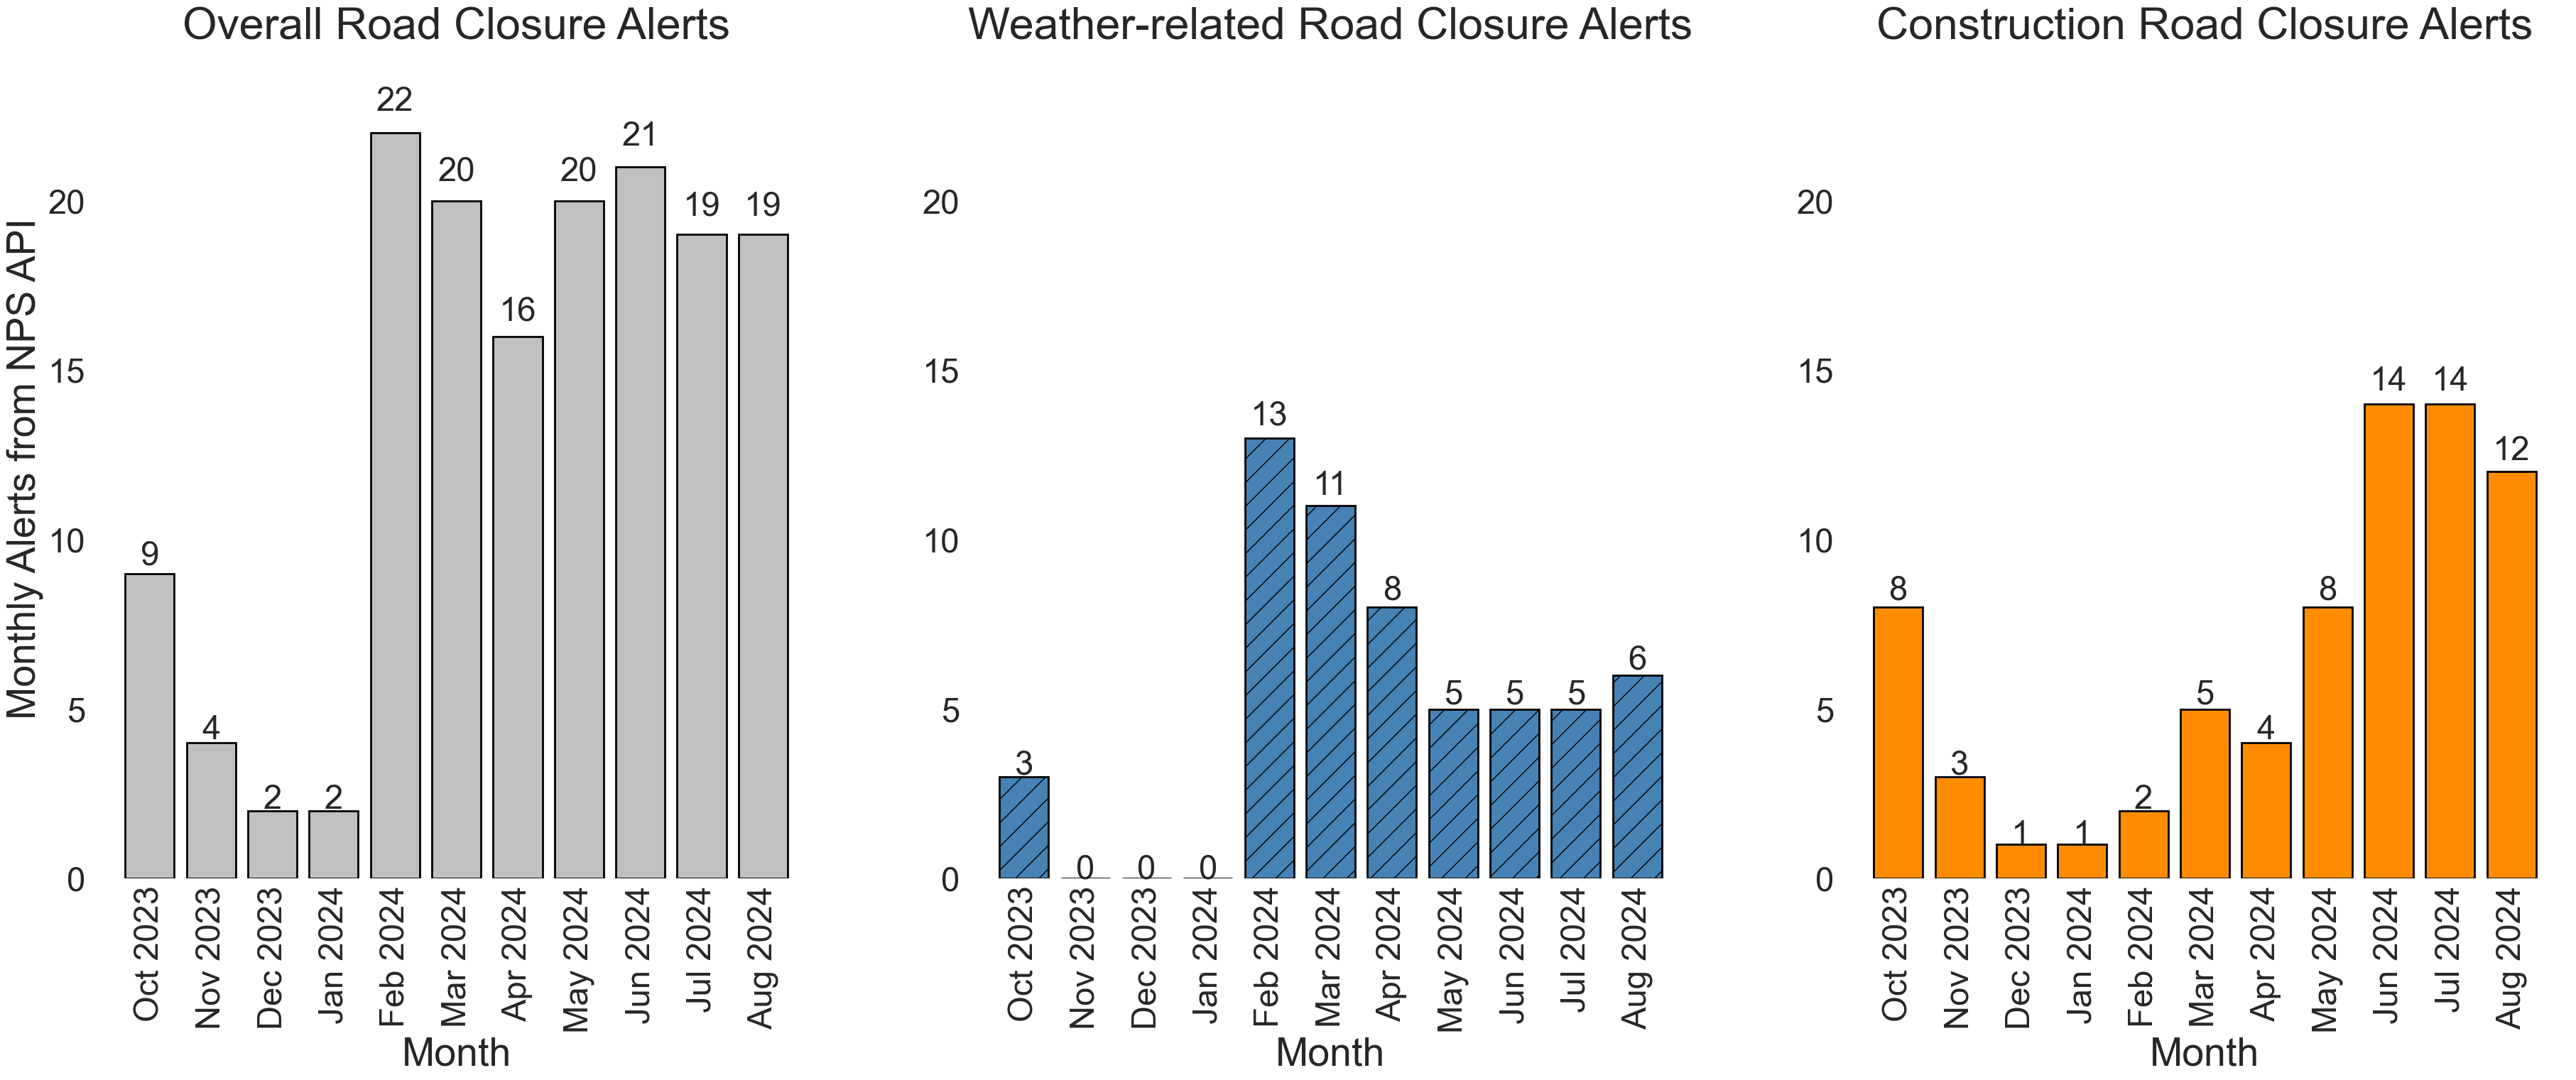

In [68]:
fig, ax = plt.subplots(1,3,figsize=(45,15))

tick_spacing = 1
graph_title_total = "Overall Road Closure Alerts"
graph_title_weather = "Weather-related Road Closure Alerts"
graph_title_construction = "Construction Road Closure Alerts"
xaxis_title = "Month"
yaxis_title = "Monthly Alerts from NPS API"

#subplot data
ax[0].bar(monthly_df_tdx['months'], monthly_df_tdx['Road Closed Flag'], edgecolor="black", linewidth=2, color = 'silver')
ax[1].bar(monthly_df_tdx['months'], monthly_df_tdx['Overall: Weather'], edgecolor="black", linewidth=2, hatch = "/", color = "steelblue")
ax[2].bar(monthly_df_tdx['months'], monthly_df_tdx['Construction'],  edgecolor="black", linewidth=2, color = "darkorange")

bar_max = 1.1*monthly_df_tdx['Road Closed Flag'].max()

for i in range(len(monthly_df_tdx['months'])):
    ax[0].text(i, monthly_df_tdx['Road Closed Flag'][i]*1.03, str(monthly_df_tdx['Road Closed Flag'][i]), ha = 'center',  fontsize = 34)

for i in range(len(monthly_df_tdx['months'])):
    ax[1].text(i, (monthly_df_tdx['Overall: Weather'][i])*1.03, str(monthly_df_tdx['Overall: Weather'][i]), ha = 'center',  fontsize = 34)

for i in range(len(monthly_df_tdx['months'])):
    ax[2].text(i, monthly_df_tdx['Construction'][i]*1.03, str(monthly_df_tdx['Construction'][i]), ha = 'center',  fontsize = 34)


#make graph pretty
ax[0].set_ylim([0, bar_max])
ax[0].set_title(graph_title_total,fontsize= 45, pad = 20) # title of plot
ax[0].set_xlabel(xaxis_title,fontsize = 40) #xlabel
ax[0].set_ylabel(yaxis_title, fontsize = 40)#ylabel
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[0].tick_params(axis='x', which='major', labelsize=34, rotation=90)
ax[0].tick_params(axis='y', which='major', labelsize=34)
ax[0].tick_params(axis='both', which='minor', labelsize=8)
ax[0].grid('off')
ax[0].grid(False)

#make graph pretty
ax[1].set_ylim([0, bar_max])
ax[1].set_title(graph_title_weather,fontsize= 45, pad = 20) # title of plot
ax[1].set_xlabel(xaxis_title,fontsize = 40) #xlabel
#ax[1].set_ylabel(yaxis_title, fontsize = 30)#ylabel
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[1].tick_params(axis='x', which='major', labelsize=34, rotation=90)
ax[1].tick_params(axis='y', which='major', labelsize=34)
ax[1].tick_params(axis='both', which='minor', labelsize=8)
ax[1].grid('off')
ax[1].grid(False)

#make graph pretty
ax[2].set_ylim([0, bar_max])
ax[2].set_title(graph_title_construction,fontsize= 45, pad = 20) # title of plot
ax[2].set_xlabel(xaxis_title,fontsize = 40) #xlabel
#ax[2].set_ylabel(yaxis_title, fontsize = 30)#ylabel
ax[2].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[2].tick_params(axis='x', which='major', labelsize=34, rotation=90)
ax[2].tick_params(axis='y', which='major', labelsize=34)
ax[2].tick_params(axis='both', which='minor', labelsize=8)
ax[2].grid('off')
ax[2].grid(False)



output_dir = 'Figures/Combined across Regions'
os.makedirs(output_dir, exist_ok=True)

# Save the figure as a PNG file at 150 DPI
output_path = os.path.join(output_dir, 'overall_wzdx_types_subplots.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')

plt.show()

In [61]:
filtered_df_tdx.columns

Index(['index', 'date', 'park', 'alert name', 'description', 'event type',
       'road name', 'vehicle impact', 'event start date', 'alert_id', 'region',
       'alpha', 'State', 'year_month', 'Road Closed Flag', 'Winter', 'Summer',
       'Extreme Weather', 'Wildfire', 'Construction'],
      dtype='object')

In [62]:
filtered_df_tdx.groupby(['date', "region"]).sum(numeric_only=True).reset_index()

,date,region,index,Road Closed Flag,Winter,Summer,Extreme Weather,Wildfire,Construction
0,2023-10-23,IMR,312,1,0,0,0,0,1
1,2023-10-23,NER,3,3,1,0,0,0,2
2,2023-10-23,PWR,2925,4,1,0,2,0,4
3,2023-10-23,SER,471,1,0,0,0,0,1
4,2023-11-27,IMR,516,1,0,0,0,0,0
5,2023-11-27,NER,3,1,0,0,0,0,1
6,2023-11-27,PWR,408,1,0,0,0,0,1
7,2023-11-27,SER,472,1,0,0,0,0,1
8,2023-12-28,IMR,517,1,0,0,0,0,0
9,2023-12-28,PWR,728,1,0,0,0,0,1


In [63]:
monthly_df_reg_tdx = filtered_df_tdx.groupby(['date', "region"]).sum(numeric_only=True).reset_index()
monthly_df_reg_tdx['year_month'] = monthly_df_reg_tdx['date'].dt.to_period('M').dt.to_timestamp()
monthly_df_reg_tdx['Unknown'] = monthly_df_reg_tdx['Road Closed Flag'] - monthly_df_reg_tdx['Winter'] - monthly_df_reg_tdx['Summer'] - monthly_df_reg_tdx['Extreme Weather'] - monthly_df_reg_tdx['Wildfire'] - monthly_df_reg_tdx['Construction']
monthly_df_reg_tdx['Overall: Weather'] = monthly_df_reg_tdx['Winter'] + monthly_df_reg_tdx['Summer'] + monthly_df_reg_tdx['Extreme Weather'] + monthly_df_reg_tdx['Wildfire'] 

monthly_df_reg_tdx['months'] = monthly_df_reg_tdx.date.dt.strftime("%b %Y")
monthly_df_reg_tdx

,date,region,index,Road Closed Flag,Winter,Summer,Extreme Weather,Wildfire,Construction,year_month,Unknown,Overall: Weather,months
0,2023-10-23,IMR,312,1,0,0,0,0,1,2023-10-01,0,0,Oct 2023
1,2023-10-23,NER,3,3,1,0,0,0,2,2023-10-01,0,1,Oct 2023
2,2023-10-23,PWR,2925,4,1,0,2,0,4,2023-10-01,-3,3,Oct 2023
3,2023-10-23,SER,471,1,0,0,0,0,1,2023-10-01,0,0,Oct 2023
4,2023-11-27,IMR,516,1,0,0,0,0,0,2023-11-01,1,0,Nov 2023
5,2023-11-27,NER,3,1,0,0,0,0,1,2023-11-01,0,0,Nov 2023
6,2023-11-27,PWR,408,1,0,0,0,0,1,2023-11-01,0,0,Nov 2023
7,2023-11-27,SER,472,1,0,0,0,0,1,2023-11-01,0,0,Nov 2023
8,2023-12-28,IMR,517,1,0,0,0,0,0,2023-12-01,1,0,Dec 2023
9,2023-12-28,PWR,728,1,0,0,0,0,1,2023-12-01,0,0,Dec 2023


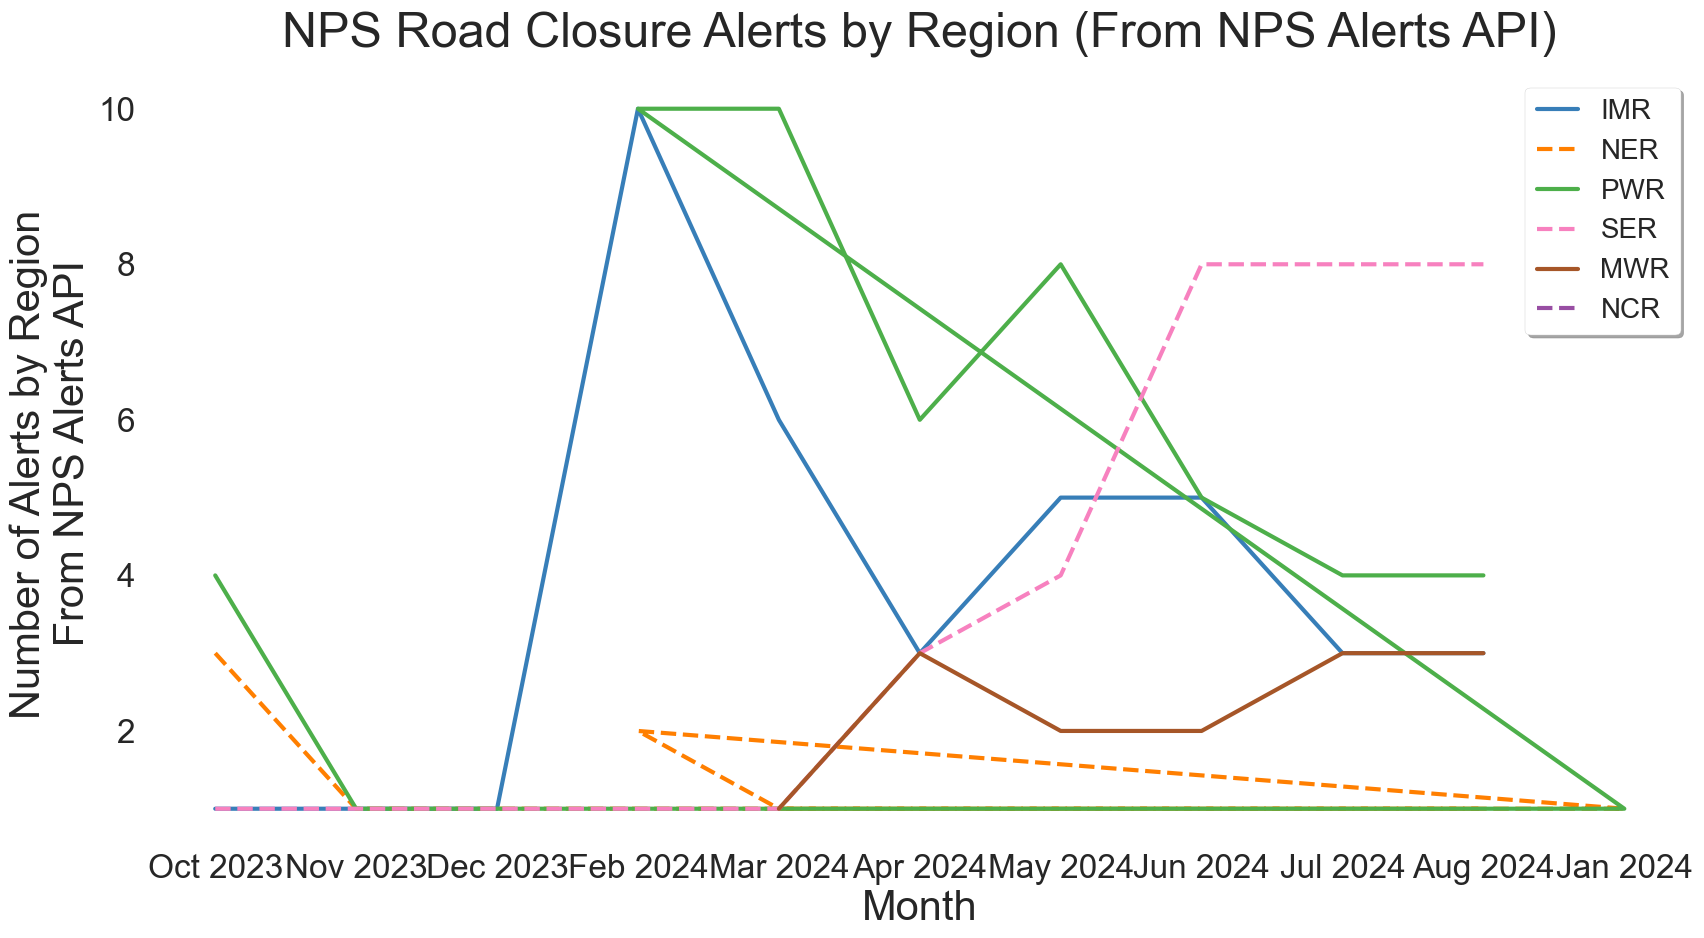

In [65]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
graph_title = "NPS Road Closure Alerts by Region (From NPS Alerts API)"
axis_title = "Number of Alerts by Region \n From NPS Alerts API"
plt.style.use("seaborn-v0_8-dark-palette")
sns.set_style("white")

#plt.color_palette("husl")
cmap = mpl.cm.cool
fig, ax = plt.subplots(1,1,figsize=(20,10))
tick_spacing = 1

counter = 0
linestyle_list = ["solid", "dashed","solid", "dashed","solid", "dashed","solid", "dashed","solid", "dashed"]
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
#linestyle_list = ["solid", "dashed","solid", "dashed","solid", "dashed","solid", "dashed","solid", "dashed"]
for x in monthly_df_reg_tdx.region.unique():
    temp_df = monthly_df_reg_tdx[monthly_df_reg_tdx['region']==x]
    plt.plot(temp_df['months'],
            temp_df["Road Closed Flag"], label = x, linewidth=3, linestyle = linestyle_list[counter],
            color = CB_color_cycle[counter])
    counter+=1
    




#make graph pretty
#ax.set_ylim([0, bar_max*1.1])
#ax.set_xlim([0, 460])
ax.set_title(graph_title,fontsize= 35, pad = 20) # title of plot

ax.set_xlabel('Month',fontsize = 30) #xlabel
ax.set_ylabel(axis_title, fontsize = 30)#ylabel
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis='x', which='major', labelsize=24)
ax.tick_params(axis='y', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.grid('off')
ax.legend(fontsize = 20, frameon=True,fancybox = True,shadow=True, handlelength=1.5,framealpha=1, )
plt.grid(False)

output_dir = 'Figures/By Type and By Region'
os.makedirs(output_dir, exist_ok=True)

# Save the figure as a PNG file at 150 DPI
output_path = os.path.join(output_dir, 'overall_roadevents_by_region.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')

plt.show()

KeyError: 'Unknown'

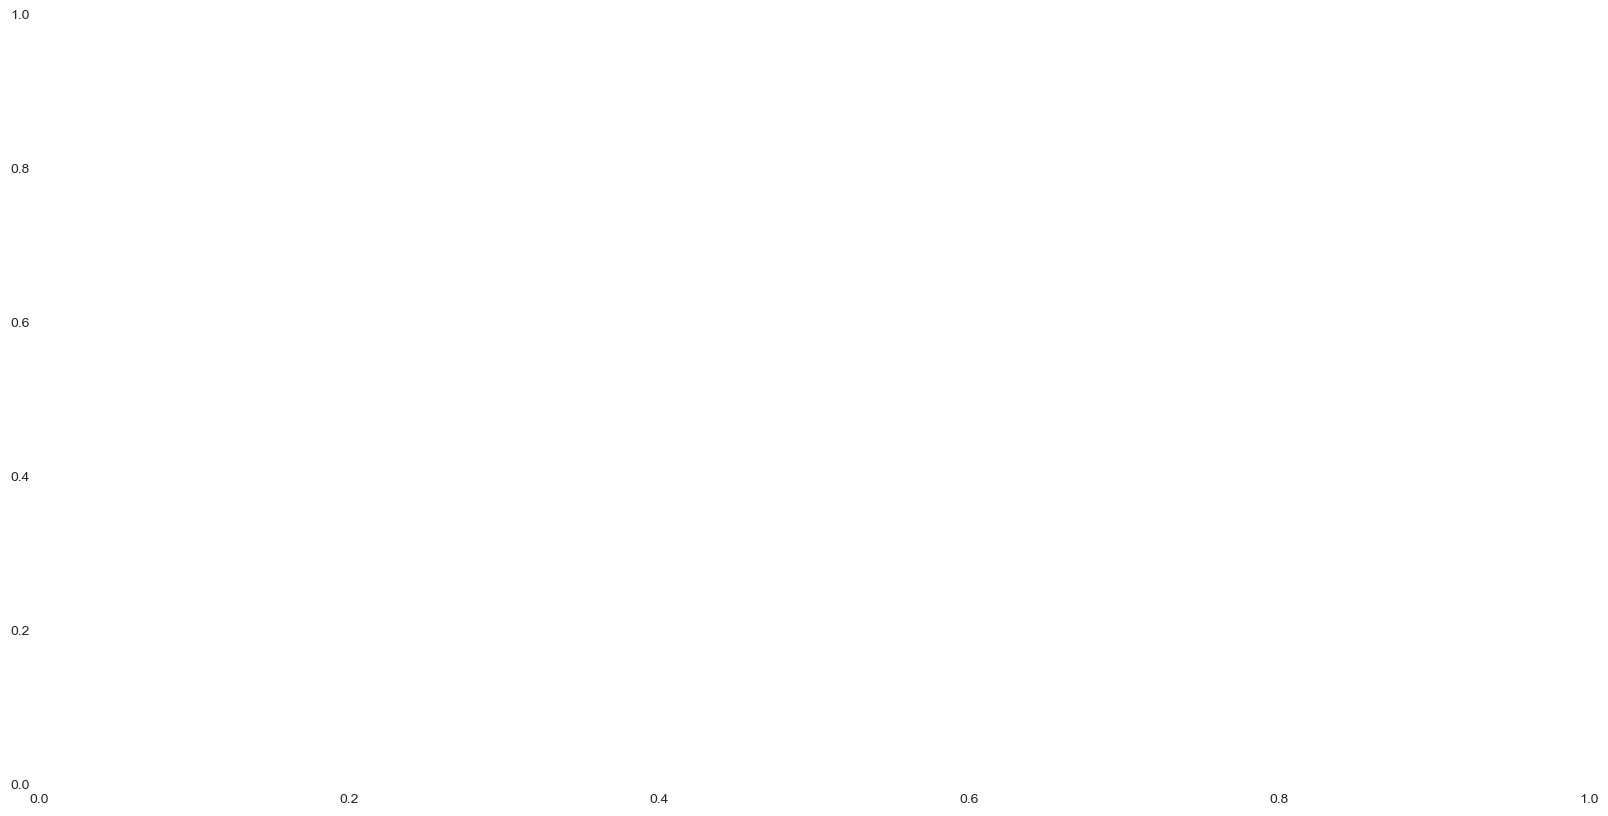

In [228]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
graph_title = "NPS Road Closure Alerts by Type (From NPS Road Events API)"
axis_title = "Number of Alerts by Type \n From NPS Road Events API"
plt.style.use("seaborn-v0_8")
sns.set_style("white")

#plt.color_palette("husl")
cmap = mpl.cm.cool
fig, ax = plt.subplots(1,1,figsize=(20,10))
tick_spacing = 1


plt.bar(monthly_df_tdx['months'],
        monthly_df_tdx['Unknown'], label = "General", color = "silver")

plt.bar(monthly_df_tdx['months'],
        monthly_df_tdx['Overall: Weather'], label = "Overall: Weather", bottom = monthly_df_tdx['Unknown'], hatch = "/",
       color = "steelblue")

plt.bar(monthly_df_tdx['months'],
        monthly_df_tdx['Construction'],  bottom = monthly_df_tdx['Unknown']+ monthly_df_tdx['Overall: Weather'],
label = "Construction", color = "darkorange")


bar_max = 1.15*monthly_df_tdx['Road Closed Flag'].max()

for i in range(len(monthly_df_tdx['months'])):
    plt.text(i, monthly_df_tdx['Road Closed Flag'][i]*1.03, str(monthly_df_tdx['Road Closed Flag'][i]) + " Total", ha = 'center',  fontsize = 24)

for i in range(len(monthly_df_tdx['months'])):
    plt.text(i, monthly_df_tdx['Unknown'][i]*.5, str(monthly_df_tdx['Unknown'][i]) + " General", ha = 'center',  fontsize = 18)

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

for i in range(len(monthly_df_tdx['months'])):
    plt.text(i, (monthly_df_tdx['Unknown'][i]+monthly_df_tdx['Overall: Weather'][i])*.75, str(monthly_df_tdx['Overall: Weather'][i]) + " Weather", 
             ha = 'center',  fontsize = 18, bbox=bbox_props)

for i in range(len(monthly_df_tdx['months'])):
    plt.text(i, monthly_df_tdx['Road Closed Flag'][i]*.85, str(monthly_df_tdx['Construction'][i]) + " Construction", ha = 'center',  fontsize = 18)


#make graph pretty
ax.set_ylim([0, bar_max*1.1])
#ax.set_xlim([0, 460])
ax.set_title(graph_title,fontsize= 35, pad = 20) # title of plot

ax.set_xlabel('Month',fontsize = 30) #xlabel
ax.set_ylabel(axis_title, fontsize = 30)#ylabel
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis='x', which='major', labelsize=24)
ax.tick_params(axis='y', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.grid('off')
ax.legend(fontsize = 20, frameon=True,fancybox = True,shadow=True, handlelength=1.5,framealpha=1, )
plt.grid(False)

output_dir = 'Figures/Combined across Regions'
os.makedirs(output_dir, exist_ok=True)

# Save the figure as a PNG file at 150 DPI
output_path = os.path.join(output_dir, 'overall_road_events_api_types.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')

plt.show()

In [ ]:
plt.bar(115, [0, bar_max/1.05], width = 30, color = 'gray', alpha = 0.15)
plt.bar(290, [0, bar_max/1.05], width = 20, color = 'gray', alpha = 0.15)
plt.bar(385, [0, bar_max/1.05], width = 30, color = 'gray', alpha = 0.15)

ax.text(95, bar_max,
           'Roanoke, VA\nMP 100-130', fontsize=15)

ax.text(275,bar_max,
           ' Boone, NC\nMP 280-300', fontsize=15)
ax.text(365, bar_max,
           'Asheville,NC\nMP 370-400', fontsize=15)
ax.vlines([100, 130, 280, 300, 370,400], ymin=0, ymax = bar_max/1.05,
            linestyles = "dotted", linewidth = 2)
ax.vlines([220], ymin=0, ymax = bar_max*1.5,
            linestyles = "dotted", linewidth = 5, color = 'black')
ax.hlines([0], xmin = 0, xmax = 460,
            linestyles = "solid", linewidth = 3, color = 'black')
ax.text(175, bar_max*1.4, 'Virginia', fontsize=25)
ax.text(228, bar_max*1.4, 'North Carolina', fontsize=25)
#ax.text(200, bar_max*1.15, 'VA', fontsize=25)
#ax.text(225, bar_max*1.15, 'NC', fontsize=25)
#ax.bar(ten_mile_markers_for_graph, ten_mile_signs,width = 5,label ="Stop Signs")

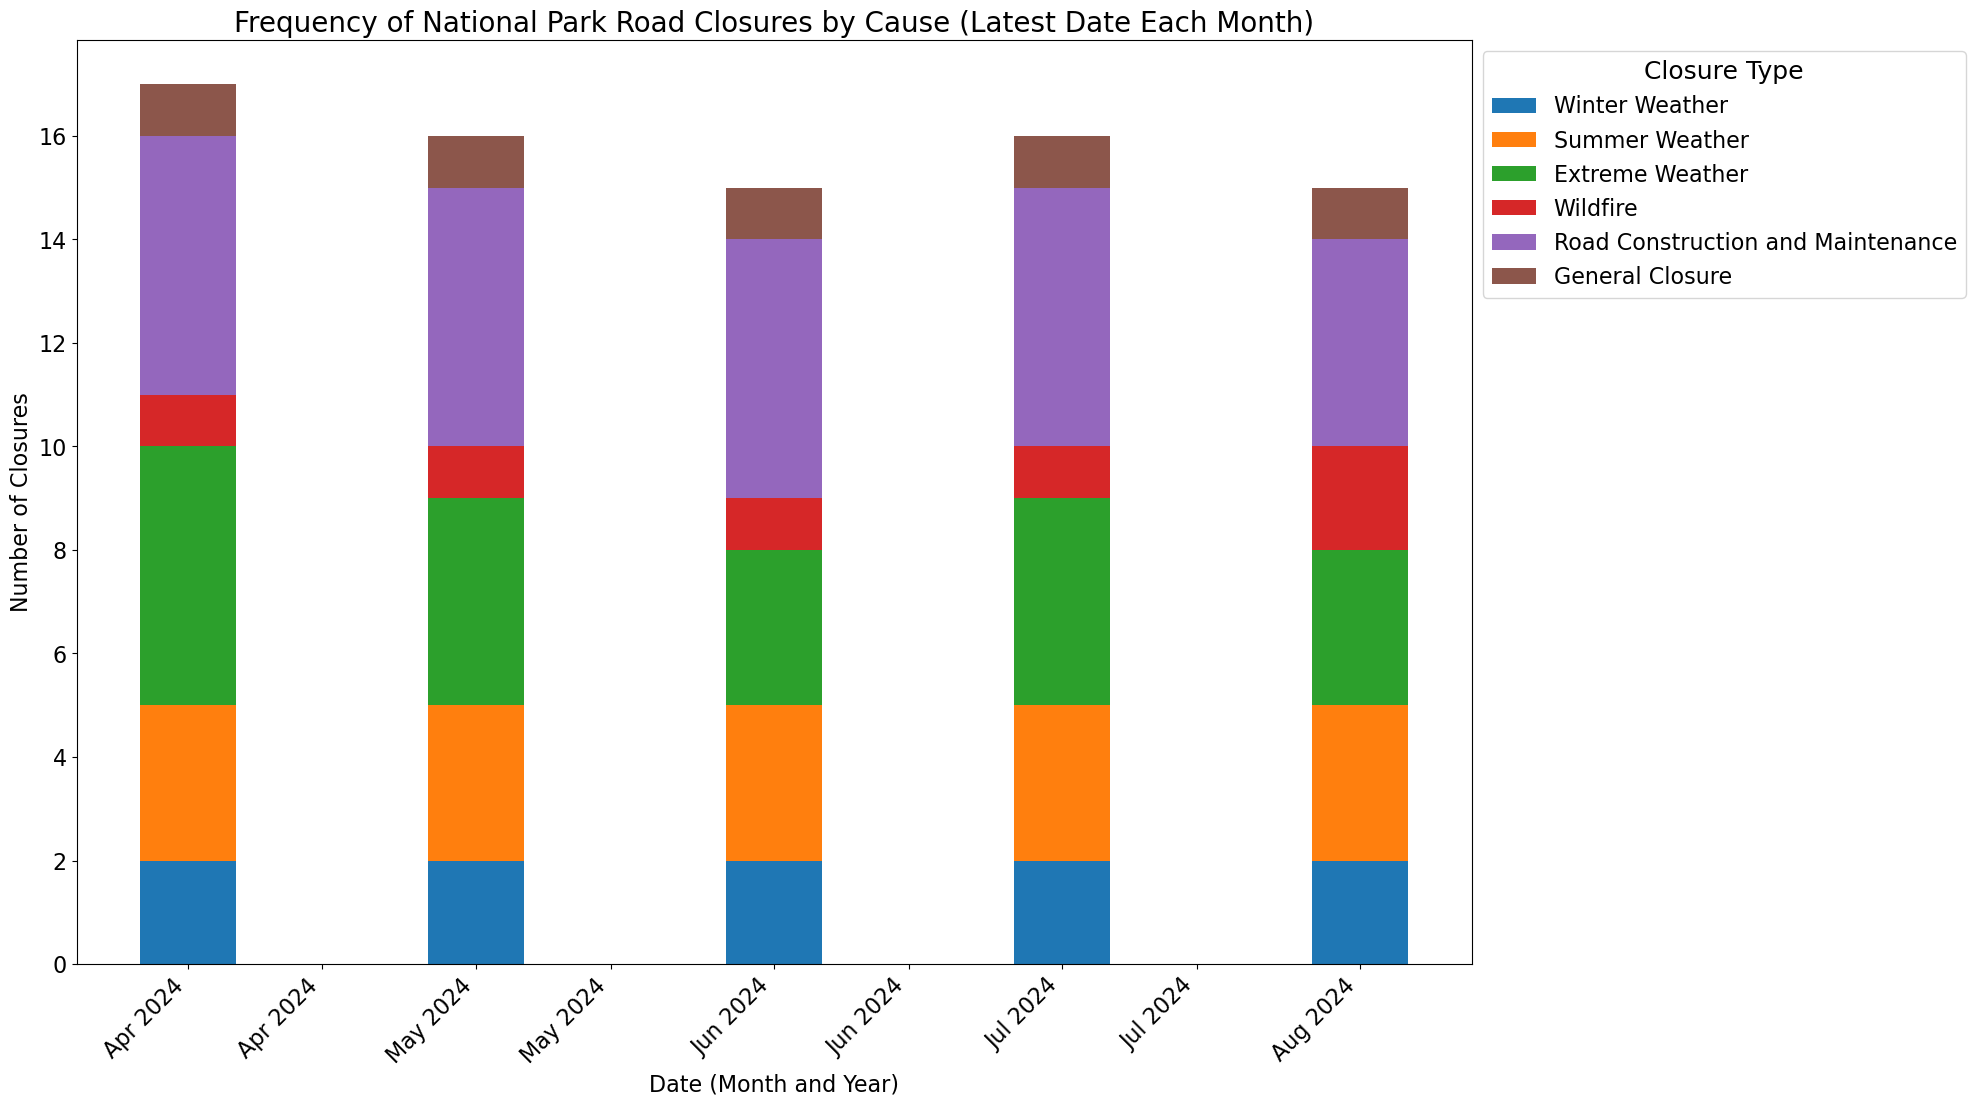

In [8]:
# Plotting the stacked bar chart
plt.figure(figsize=(18, 12))

# Ensure y-axis only shows whole numbers
plt.gca().yaxis.get_major_locator().set_params(integer=True)



# Increase font sizes and update labels
plt.title('Frequency of National Park Road Closures by Cause (Latest Date Each Month)', fontsize=20)
plt.xlabel('Date (Month and Year)', fontsize=16)
plt.ylabel('Number of Closures', fontsize=16)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Closure Type', fontsize=16, title_fontsize=18, loc='upper left', bbox_to_anchor=(1,1))


plt.show()


In [ ]:
# Create the directories if they don't exist
output_dir = 'Figures/Combined across Regions'
os.makedirs(output_dir, exist_ok=True)

# Save the figure as a PNG file at 150 DPI
output_path = os.path.join(output_dir, 'closure_types_over_time.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')
